<a href="https://colab.research.google.com/github/sanjanabayya30/Proj/blob/main/Q_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔧 Job-Machine-Time Assignments:
 Job ID  Operation  Machine  Start  End  Current Makespan  Contributes to Makespan
      0          0        0      0   29                29                    False
      0          1        1      0   78                78                    False
      0          2        2      0    9                78                    False
      0          3        3      0   36                78                    False
      0          4        4      0   49                78                    False
      0          5        5      0   11                78                    False
      0          6        6      0   62                78                    False
      0          7        7      0   56                78                    False
      0          8        8      0   44                78                    False
      0          9        9      0   21                78                    False
      3          0        2      9   90               

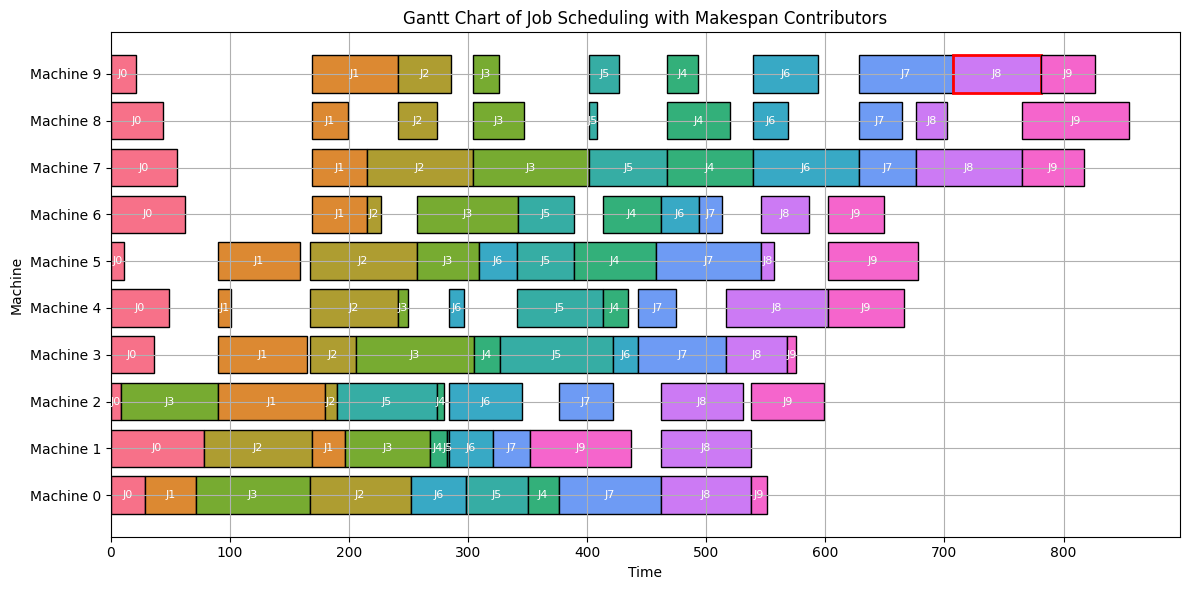

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
import seaborn as sns

# Load the dataset (using FT06 for demonstration)
df = pd.read_csv("/content/drive/MyDrive/FT10_Dataset.zip")
df["Machine"] = df["Machine"].apply(lambda x: int(x[1:]))

# Extract basic parameters
num_jobs = df["Job ID"].nunique()
num_machines = df["Machine"].nunique()
operations_per_job = df.groupby("Job ID")["Operation"].max().iloc[0] + 1

# Build job operation mapping
job_operations = defaultdict(list)
for _, row in df.iterrows():
    job_operations[int(row["Job ID"])].append((int(row["Operation"]), int(row["Machine"]), int(row["Processing Time"])))
for job in job_operations:
    job_operations[job].sort(key=lambda x: x[0])

# Q-Learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodes = 5000

Q = defaultdict(float)

def get_available_jobs(job_progress):
    return [j for j in range(num_jobs) if job_progress[j] < operations_per_job]

def get_feasible_machines(job_progress, machine_status, t):
    feasible = []
    for job in get_available_jobs(job_progress):
        op_num = job_progress[job]
        _, m, _ = job_operations[job][op_num]
        if machine_status[m] <= t:
            feasible.append((job, m))
    return feasible

def get_next_action(state):
    available_actions = [k for k in Q.keys() if k[0] == state]
    if not available_actions or random.random() < epsilon:
        return random.choice(get_available_jobs(state[0]))
    else:
        return max(available_actions, key=lambda k: Q[k])[1]

def simulate_schedule(Q, train=False):
    job_progress = [0] * num_jobs
    machine_status = [0] * (num_machines + 1)
    schedule = []
    time = 0
    total_idle = 0

    while any(p < operations_per_job for p in job_progress):
        feasible = get_feasible_machines(job_progress, machine_status, time)

        if not feasible:
            time += 1
            total_idle += 1
            continue

        for job, machine in feasible:
            op_num, m, pt = job_operations[job][job_progress[job]]
            start = max(machine_status[m], time)
            end = start + pt

            state = (tuple(job_progress), tuple(machine_status))
            action = job

            if train:
                next_job_progress = job_progress.copy()
                next_job_progress[job] += 1
                next_machine_status = machine_status.copy()
                next_machine_status[m] = end
                next_state = (tuple(next_job_progress), tuple(next_machine_status))
                reward = -pt

                Q[(state, action)] += alpha * (
                    reward + gamma * max(Q.get((next_state, a), 0) for a in range(num_jobs))
                    - Q[(state, action)]
                )

            job_progress[job] += 1
            machine_status[m] = end
            schedule.append((job, op_num, m, start, end))
            break

    return schedule, time, total_idle

# Training
for ep in range(episodes):
    simulate_schedule(Q, train=True)

# Evaluation
schedule, makespan, total_idle = simulate_schedule(Q, train=False)

# Convert schedule to DataFrame
schedule_df = pd.DataFrame(schedule, columns=["Job ID", "Operation", "Machine", "Start", "End"])
idle_machines = num_machines * makespan - schedule_df["End"].sub(schedule_df["Start"]).sum()

# Sort by start time
schedule_df.sort_values(by="Start", inplace=True)

# Add per-line makespan contribution
schedule_df["Current Makespan"] = schedule_df["End"].cummax()
schedule_df["Contributes to Makespan"] = schedule_df["End"] == makespan

# Display results
print("\n🔧 Job-Machine-Time Assignments:")
print(schedule_df.to_string(index=False))
print(f"\n📊 Total Makespan: {makespan}")
print(f"🛠️ Idle Machine Time Units: {idle_machines}")
print(f"⏳ Job Wait Time Units (idle steps during scheduling): {total_idle}")

# Gantt Chart with makespan contribution highlighting
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", num_jobs)
for i, row in schedule_df.iterrows():
    color = colors[row["Job ID"]]
    edge = 'red' if row["Contributes to Makespan"] else 'black'
    lw = 2 if row["Contributes to Makespan"] else 1
    plt.barh(y=f"Machine {row['Machine']}", width=row["End"] - row["Start"],
             left=row["Start"], color=color, edgecolor=edge, linewidth=lw)
    plt.text(x=row["Start"] + (row["End"] - row["Start"]) / 2,
             y=f"Machine {row['Machine']}",
             s=f"J{row['Job ID']}",
             va='center', ha='center', color='white', fontsize=8)
plt.title("Gantt Chart of Job Scheduling with Makespan Contributors")
plt.xlabel("Time")
plt.ylabel("Machine")
plt.grid(True)
plt.tight_layout()
plt.show()